In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [3]:
unique_immigration_df = pd.read_csv("./unique_immigration_104_107.csv")

In [106]:
bill_nums = unique_immigration_df["bill_title"] 
bill_titles = unique_immigration_df["question"]
content = unique_immigration_df["bill_long_text"]
years = unique_immigration_df["year"]

In [30]:
stopwords = nltk.corpus.stopwords.words('english')

In [31]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [32]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [33]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in content:
    
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [34]:
# keeping only the first mapping of a stemmed to a tokanized word
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
str(vocab_frame.shape[0])

'564919'

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(content) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 26.5 s, sys: 503 ms, total: 27 s
Wall time: 27.1 s
(114, 1409)


In [37]:
terms = tfidf_vectorizer.get_feature_names()

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [39]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 290 ms, sys: 6.1 ms, total: 296 ms
Wall time: 187 ms


In [41]:
from sklearn.externals import joblib

# joblib.dump(km, 'bill_cluster.pkl')

km = joblib.load('bill_cluster.pkl')
clusters = km.labels_.tolist()

In [151]:
bills = { 'number': bill_nums, 'content': content, 'cluster': clusters, 'year': years, 'title':bill_titles}

# frame = pd.DataFrame(bills, index = [clusters] , columns = ['title', 'number', 'cluster', 'year'])
frame_test = pd.DataFrame(bills)
frame_test.to_csv('text.csv', columns = ['title', 'number', 'cluster', 'year'])

In [156]:
print (len(bill_nums))
print (len(content))
print (len(clusters))
print (len(years))
print (len(bill_titles))
print (len(bills))
# print (unique_immigration_df["bill_title"].unique())
# print (frame_test.number.unique())

114
114
114
114
114
5


In [215]:
grouped_frame = frame_test.groupby(["cluster"])
clusterGroup = []
for i, group in grouped_frame:
    clusterGroup.append(group)

In [218]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
title_cluster_list = []
clusters_words = []
cluster_titles = []
cluster_center_words = []

for i, group in grouped_frame:
    
    tmp_cluster_center_words = []
    for ind in order_centroids[i, :300]:
        tmp_cluster_center_words.append(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'))
    cluster_center_words.append(tmp_cluster_center_words)
    
    clusterWord = []
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :30]:
        clusterWord.append(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'))
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    clusters_words.append(clusterWord)
    print()
    print()
    
    print("Cluster %d title:" % i, end='')
    for row in clusterGroup[i].iterrows():
        num = row[1]["number"]
        print (' %s,' % num, end='') 
    print()
    print(),

Top terms per cluster:

Cluster 0 words: alien, visa, amends, immigrant, nations, immigrant, amends, attorney, attorney, petition, directs, directs, nonimmigrant, deportation, border, consideration, illegal, illegal, forth, set, child, adopt, u.s., set, age, closed, respect, natural, sponsor, parents,

Cluster 0 title: s1664, hr668, hres384, hres528, hr2202, hr4134, s1723, hr2027, s1161, hr2464, hr1493, hr2920, hr1428, hr2578, hr3736, s2045, hr2886, hr1885, hr1209, hr1892, hres396, hr3525, hr4858, hr2155,

Cluster 1 words: funding, department, federal, appropriations, administration, agencies, title, officer, make, secretary, supplemental, assistance, available, fy, prohibitions, emergency, supplemental, agriculture, health, related, loan, chapter, educational, sec, rescinds, management, defense, development, housing, commissions,

Cluster 1 title: hr4278, hr889, hr1158, hr1944, hr3019, hr3814, hr3610, s1061, hr1469, hr1871, hjres94, hr2264, hr4328, s544, s1233, hr1141, hr1906, hr2670,

In [268]:
# clusters_words[4]
list_james = []
for i in bills["cluster"]:
    for j in range(len(clusters_words)):
        if i == j:
            words = clusters_words[j]
            list_james.append(words)

bills["words_in_cluster"] = list_james

In [272]:
final_frame = pd.DataFrame(bills)
final_frame.to_csv('final_frame.csv', index=False, columns = ['title', 'number', 'cluster', 'year', "words_in_cluster"])

## Scaling

In [274]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [277]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'alien, visa, deportation', 
                 1: 'funding, department, federal', 
                 2: 'federal, court, funding', 
                 3: 'title, child, secretary', 
                 4: 'secretary, u.s., united'}

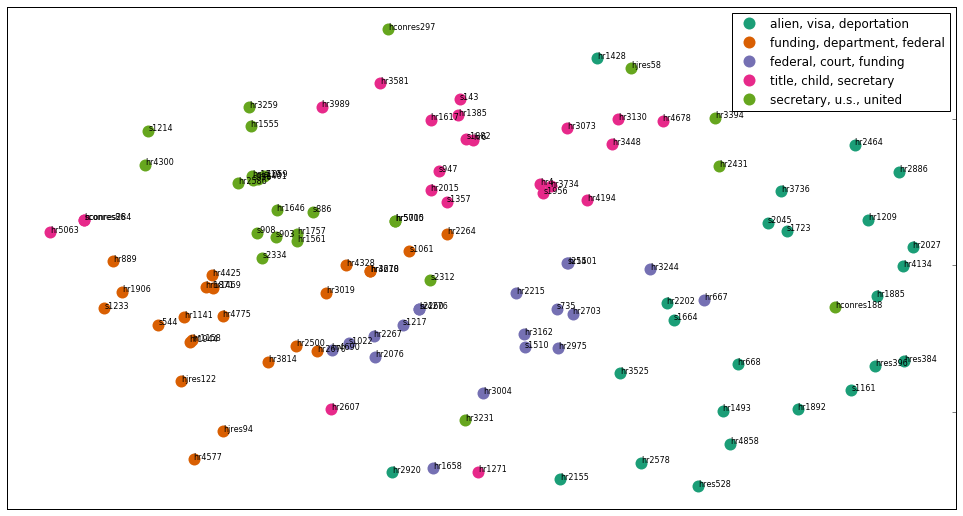

In [280]:

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=bill_nums)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot


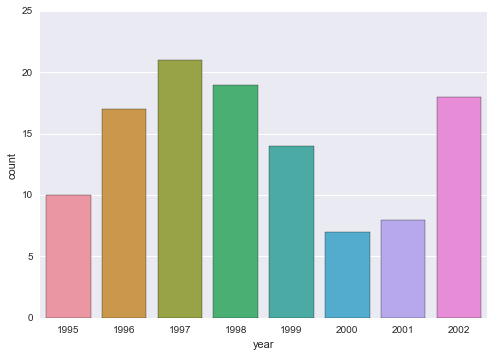

In [293]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="year", data=unique_immigration_df)